# Eksperymenty z modelami opisujące profile pacjentów 

In [10]:
import pandas as pd
import numpy as np
import os
from typing import NamedTuple, List
from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier

In [5]:
from environment.profiles import profiles

In [6]:
from environment.fogg_behavioural_model import Patient

## Parametry eksperymentu

In [7]:
UpdatedEveryDayHours = 24
WeekHours = 7 * UpdatedEveryDayHours
ThreeWeeksHours = WeekHours * 3
EightWeeksHours = WeekHours * 8
FiveWeeksHours = WeekHours * 5

Condition = 'stable'
Habituation = False
#very high e.g. 9999999999 to make it outside of the intervention time...effectively no preference shift
TimePreferenceUpdateStep = 9999999999999999
# 500 runs in the paper
RunCount = 1

In [8]:
ResultsDirectory = 'results'
if not os.path.exists(ResultsDirectory):
  os.makedirs(ResultsDirectory)

## Opisy profili
### Profil 0 - pacjent z niskim poziomem motywacji
- [profile_0_indifferent](./simulator/environment/profile_0_indifferent.py)

### Profil 1 - 
### Profil 2 - 
### Profil 3 - pacjent z wysokim poziomem motywacji


## Metody przedstawienia wyników

In [11]:

class ExperimentResult(NamedTuple):
  sleep_hours: List[float]
  positive_mood_hours: List[float]
  response_ratios: List[float]
  notifications: List[float]


In [27]:
from typing import Dict

def plot_experiment_result_hours(result: ExperimentResult):
  (sleeps_hours, positive_moods_hours, _, _) = result

  plt.figure(figsize=(8, 5))
  plt.plot(np.nanmean(sleeps_hours, axis=0), label='Hours slept', color='r')
  plt.plot(np.mean(positive_moods_hours, axis=0), label='Hours in positive mood')
  plt.ylabel('Hours ')
  plt.xlabel('Intervention Days')
  plt.legend()
  plt.show()

def plot_experiment_result_ratios(result: ExperimentResult):
  (_, _, ratios, notifications) = result

  _, (ratios_axis, notifications_axis) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
  ratios_axis.plot(np.nanmean(ratios, axis=0), label='response ratio', color='r')
  notifications_axis.plot(np.nanmean(notifications, axis=0), label='num of notifications')
  notifications_axis.set_xlabel('Intervention days')
  notifications_axis.set_ylabel('No. of notifications')
  ratios_axis.set_ylabel('Response ratio')
  plt.show()

class ReadResult(NamedTuple):
  ratios: List[float]
  notifications: List[float]

def read_ratios_and_notifications(name: str, epoch_count: int = RunCount, condition: str = Condition) -> ReadResult:
  ratios = []
  notifications = []

  no_activity_count = 0
  for epoch in range(epoch_count):
    frame = pd.read_csv(f"{ResultsDirectory}/patient1_{condition}_{name}_run{epoch}.csv")
    has_performed_activity = any(frame['activity performed'].values)

    if has_performed_activity:
      ratios.append(frame.response_ratio)
      notifications.append(frame.notifications)
    else:
      no_activity_count += 1

  print(f" {no_activity_count} out of {epoch_count} runs had no activity performed throughout the full intervention.")
  return ReadResult(ratios, notifications)

def plot_experiment_results_ratio(label: str, not_random_result: ReadResult, result_map: Dict[str, ReadResult]):
  figure: plt.Figure
  figure, (ratios_axis, notifications_axis) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 10))
  figure.suptitle(f'profile "{label}": Comparison of prompt learning strategies', fontsize=20)
  figure.subplots_adjust(top=0.9)

  for label, (ratios, notifications) in result_map.items():
    ratios_axis.plot(np.nanmean(ratios, axis=0), label=label)
    notifications_axis.plot(np.nanmean(notifications, axis=0), label=label)

  print(f"Random result: {not_random_result}")
  notifications_axis.plot(
    np.ones(len(np.mean(not_random_result.notifications, axis=0)) + 2),
    label='Preferred number of notifications a day'
  )
  notifications_axis.set_xlabel('Intervention Days', fontsize=16)
  notifications_axis.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)), fontsize=16)
  ratios_axis.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)))
  notifications_axis.legend(fontsize=13)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()


## Experiment methods

### No intervention

In [15]:

from typing import Type

def run_no_intervention_experiment(Profile: Type[Patient], epoch_count: int = RunCount) -> ExperimentResult:
  sleep_hours = []
  positive_hours = []
  ratios = []
  notifications = []

  for _ in range(epoch_count):
    environment = Profile(
      behaviour_threshold=20,
      habituation=Habituation,
      time_preference_update_step=TimePreferenceUpdateStep
    )

    for _ in range(EightWeeksHours):
      observation, reward, done, _, info = environment.step(0)

    sleep_hours.append(environment.h_slept)
    positive_hours.append(environment.h_positive)
    ratios.append(environment.rr)
    notifications.append(environment.num_notified)

  return ExperimentResult(sleep_hours, positive_hours, ratios, notifications)


### Intervention

In [17]:
from typing import Callable

def save_epoch_to_csv(environment: Patient, condition: str, name: str, epoch: int):
  df = pd.DataFrame()
  df['response_ratio'] = environment.rr
  df['activity performed'] = environment.num_performed
  df['notifications'] = environment.num_notified
  df['sleep'] = environment.h_slept
  df['positive'] = environment.h_positive
  df['non_stationary'] = environment.h_nonstationary
  df.to_csv(f"{ResultsDirectory}/patient1_{condition}_{name}_run{epoch}.csv")

Method = Callable[[Patient], Patient]
def run_intervention_experiment(Patient: Type[Patient], method: Method, name: str, epoch_count=RunCount, condition=Condition):
  ratios = []
  notifications = []

  sleep_hours = []
  positive_mood_hours = []
  times_performed = 0

  for epoch in range(epoch_count):
    environment = method(
      Patient(
        behaviour_threshold=20,
        habituation=Habituation,
        time_preference_update_step=TimePreferenceUpdateStep
      )
    )

    if any(environment.num_performed): times_performed += 1

    save_epoch_to_csv(environment, condition, name, epoch)

    ratios.append(environment.rr)
    notifications.append(environment.num_notified)
    sleep_hours.append(environment.h_slept)
    positive_mood_hours.append(environment.h_positive)

  print("These figures include runs in which no prompt resulted in the activity being performed.")
  print(f"{times_performed} out of {epoch_count} resulted in activity being performed.")

  return ExperimentResult(sleep_hours, positive_mood_hours, ratios, notifications)


### Heuristic

Notify every hour except in night and when the patient is alseep

In [18]:
def always_notify(environment: Patient, intervention_length: int = EightWeeksHours) -> Patient:
  action = 0

  for _ in range(intervention_length):
    observation, _, _, _, _ = environment.step(action)
    # 9-th is the time of the day
    # 3 is the night
    if observation[9] == 3 or observation[3] == 1:
      action = 0
    else:
      action = 1

  return environment

### Random 
Randomly sample during the day skip the nights

In [19]:
def random_notification(environment: Patient, intervention_length: int = EightWeeksHours) -> Patient:
  action = 0
  for i in range(intervention_length):

    observation, _, _, _, _ = environment.step(action)
    # 9-th is the time of the day
    if observation[9] == 3:
      action = 0
    else:
      action = environment.action_space.sample()

  return environment

### Supervised Learning

#### Static model

In [20]:
def supervised_after_three_weeks(environment: Patient) -> Patient:
  environment = always_notify(environment, intervention_length=ThreeWeeksHours)
  classifier = RandomForestClassifier(class_weight='balanced')
  classifier.fit(environment.observation_list, environment.activity_performed)

  remaining_time = EightWeeksHours - ThreeWeeksHours
  observation = environment._get_current_state()

  for _ in range(remaining_time):
    # applying supervised model
    action = classifier.predict(np.array([observation]))[0]
    observation, _, _, _, _ = environment.step(action)

  return environment

### Adaptive model 

In [21]:
def supervised_adaptive_after_three_weeks(environment: Patient) -> Patient:
  environment = always_notify(environment, intervention_length=ThreeWeeksHours)
  classifier = RandomForestClassifier(class_weight='balanced')
  classifier.fit(environment.observation_list, environment.activity_performed)

  remaining_time = EightWeeksHours - ThreeWeeksHours
  observation = environment._get_current_state()
  samples = len(environment.observation_list)

  for _ in range(remaining_time):
    # applying supervised model
    action = classifier.predict(np.array([observation]))[0]
    observation, _, _, _, _ = environment.step(action)

    if len(environment.observation_list) <= samples: continue
    # retrain when new samples are provided
    classifier = RandomForestClassifier(class_weight='balanced')
    classifier.fit(environment.observation_list, environment.activity_performed)
    samples = len(environment.observation_list)

  return environment

### Deep Q Network

In [22]:
def dqn(environment: Patient) -> Patient:
  model = DQN("MlpPolicy", environment, verbose=0, learning_starts=UpdatedEveryDayHours)
  model.learn(total_timesteps=EightWeeksHours)
  return environment

### Proximal Policy Optimisation

In [23]:
def ppo(environment: Patient) -> Patient:
  model = PPO("MlpPolicy", environment, verbose=0, n_steps=UpdatedEveryDayHours, batch_size=UpdatedEveryDayHours)
  model.learn(total_timesteps=EightWeeksHours)
  return environment

### Advantage Actor Critic

In [24]:
def a2c(environment: Patient) -> Patient:
  model = A2C("MlpPolicy", environment, verbose=0, n_steps=UpdatedEveryDayHours)
  model.learn(total_timesteps=EightWeeksHours)
  return environment

### Comparison between prompt learning strategies

Running experiment for profile: 'Indifferent'
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being perfor

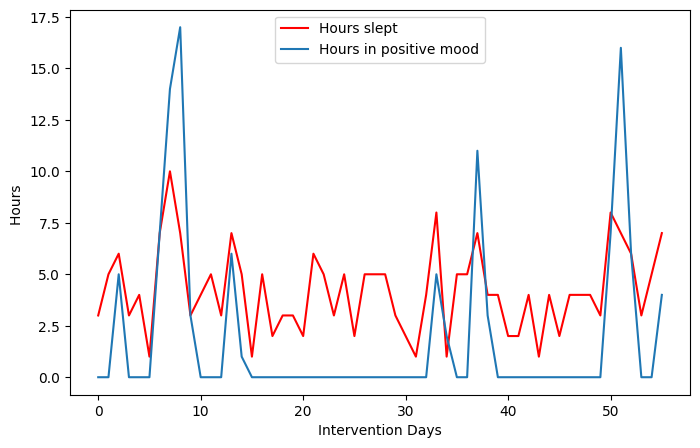

C:\Users\dan\AppData\Local\Temp\ipykernel_8364\3659124082.py:54: RuntimeWarning: Mean of empty slice
  ratios_axis.plot(np.nanmean(ratios, axis=0), label=label)
C:\Users\dan\AppData\Local\Temp\ipykernel_8364\3659124082.py:55: RuntimeWarning: Mean of empty slice
  notifications_axis.plot(np.nanmean(notifications, axis=0), label=label)


Random result: ReadResult(ratios=[0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.125000
33    0.090909
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000000
45    0.000000
46    0.142857
47    0.125000
48    0.125000
49    0.111111
50    0.111111
51    0.250000
52    0.285714
53    0.100000
54    0.100000
55    0.285714
Name: response_ratio, dtype: float64], notifications=[0      4
1      8
2      7
3      9
4      8
5      8
6      6
7      7


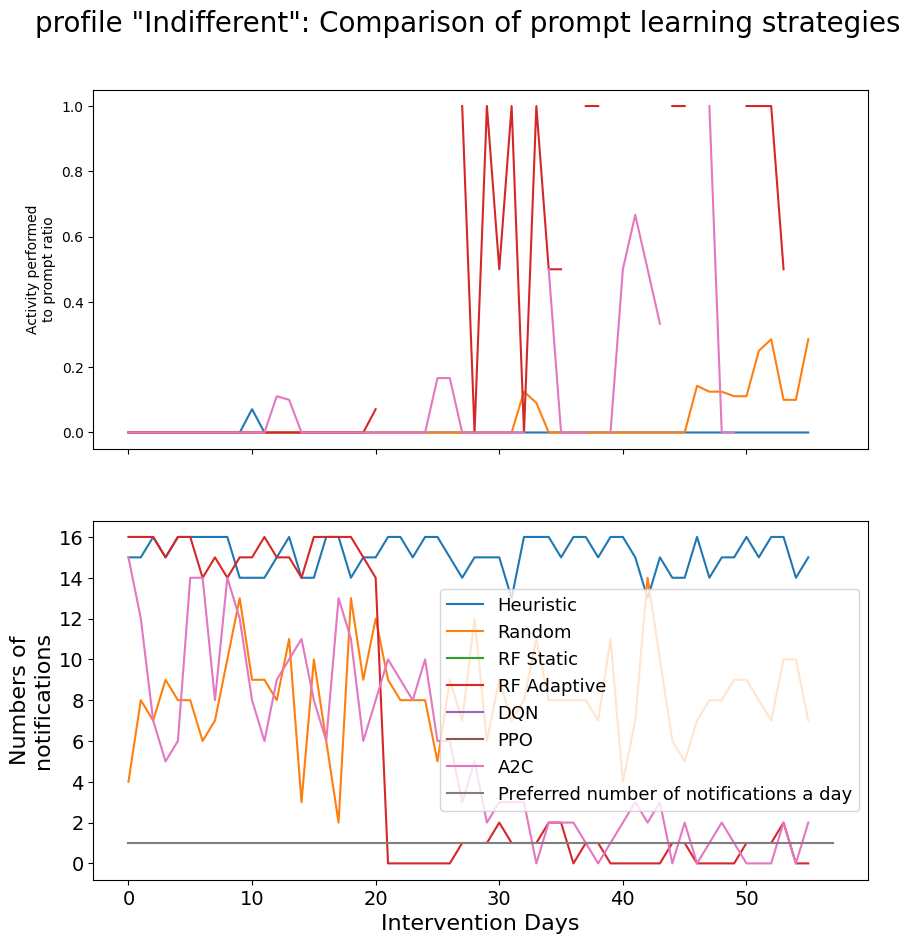


Running experiment for profile: 'Stressed'
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performe

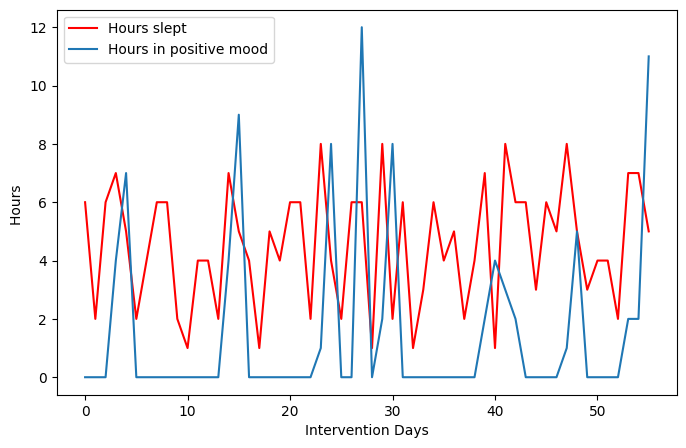

C:\Users\dan\AppData\Local\Temp\ipykernel_8364\3659124082.py:54: RuntimeWarning: Mean of empty slice
  ratios_axis.plot(np.nanmean(ratios, axis=0), label=label)
C:\Users\dan\AppData\Local\Temp\ipykernel_8364\3659124082.py:55: RuntimeWarning: Mean of empty slice
  notifications_axis.plot(np.nanmean(notifications, axis=0), label=label)


Random result: ReadResult(ratios=[0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.142857
17    0.142857
18    0.250000
19    0.142857
20    0.000000
21    0.000000
22    0.100000
23    0.250000
24    0.166667
25    0.111111
26    0.250000
27    0.083333
28    0.125000
29    0.100000
30    0.000000
31    0.125000
32    0.285714
33    0.111111
34    0.285714
35    0.125000
36    0.100000
37    0.142857
38    0.200000
39    0.100000
40    0.222222
41    0.111111
42    0.000000
43    0.000000
44    0.000000
45    0.142857
46    0.125000
47    0.125000
48    0.200000
49    0.125000
50    0.250000
51    0.125000
52    0.333333
53    0.111111
54    0.222222
55    0.250000
Name: response_ratio, dtype: float64], notifications=[0      8
1      7
2     10
3      7
4     11
5      7
6      8
7      7


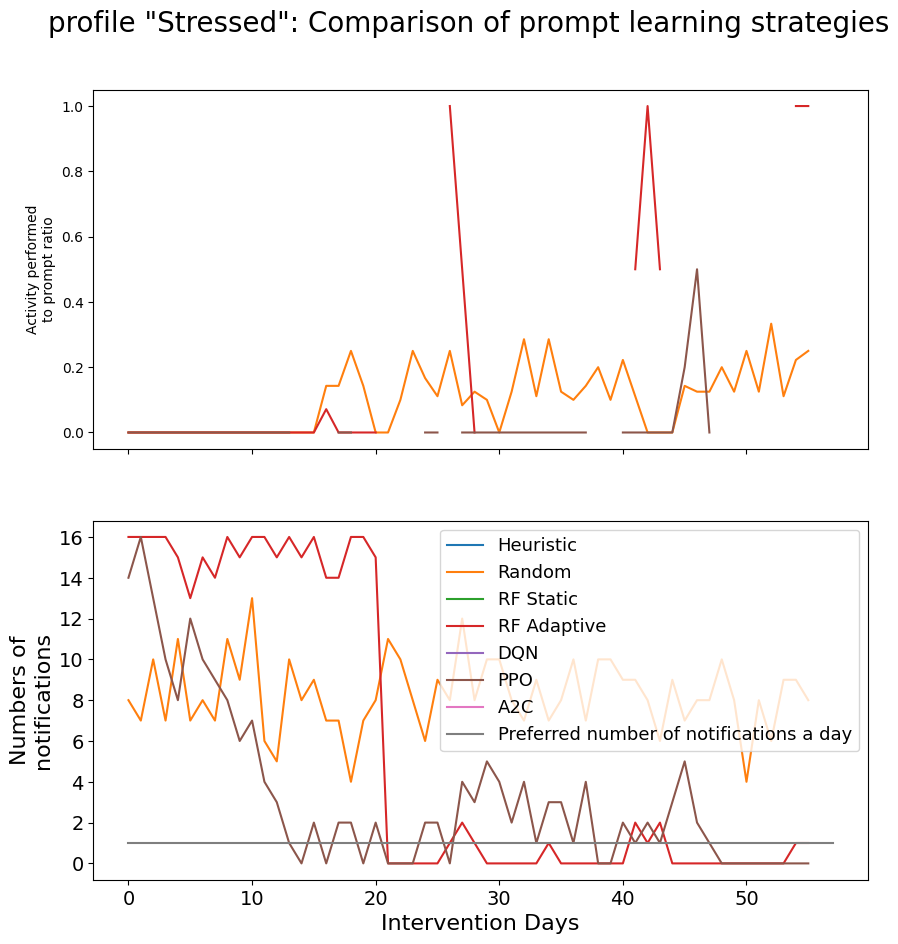


Running experiment for profile: 'Motivated'
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being perform

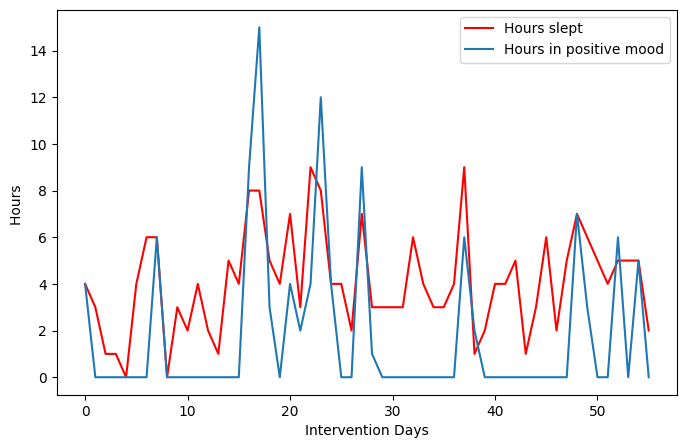

C:\Users\dan\AppData\Local\Temp\ipykernel_8364\3659124082.py:54: RuntimeWarning: Mean of empty slice
  ratios_axis.plot(np.nanmean(ratios, axis=0), label=label)
C:\Users\dan\AppData\Local\Temp\ipykernel_8364\3659124082.py:55: RuntimeWarning: Mean of empty slice
  notifications_axis.plot(np.nanmean(notifications, axis=0), label=label)


Random result: ReadResult(ratios=[0     0.125000
1     0.111111
2     0.100000
3     0.250000
4     0.111111
5     0.100000
6     0.400000
7     0.166667
8     0.166667
9     0.200000
10    0.200000
11    0.222222
12    0.100000
13    0.181818
14    0.111111
15    0.200000
16    0.111111
17    0.100000
18    0.111111
19    0.090909
20    0.100000
21    0.111111
22    0.142857
23    0.222222
24    0.166667
25    0.125000
26    0.000000
27    0.100000
28    0.125000
29    0.166667
30    0.076923
31    0.125000
32    0.000000
33    0.250000
34    0.200000
35    0.125000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.142857
42    0.125000
43    0.166667
44    0.142857
45    0.000000
46    0.000000
47    0.000000
48    0.000000
49    0.111111
50    0.111111
51    0.000000
52    0.666667
53    0.000000
54    0.125000
55    0.000000
Name: response_ratio, dtype: float64], notifications=[0      8
1      9
2     10
3      8
4      9
5     10
6      5
7      6


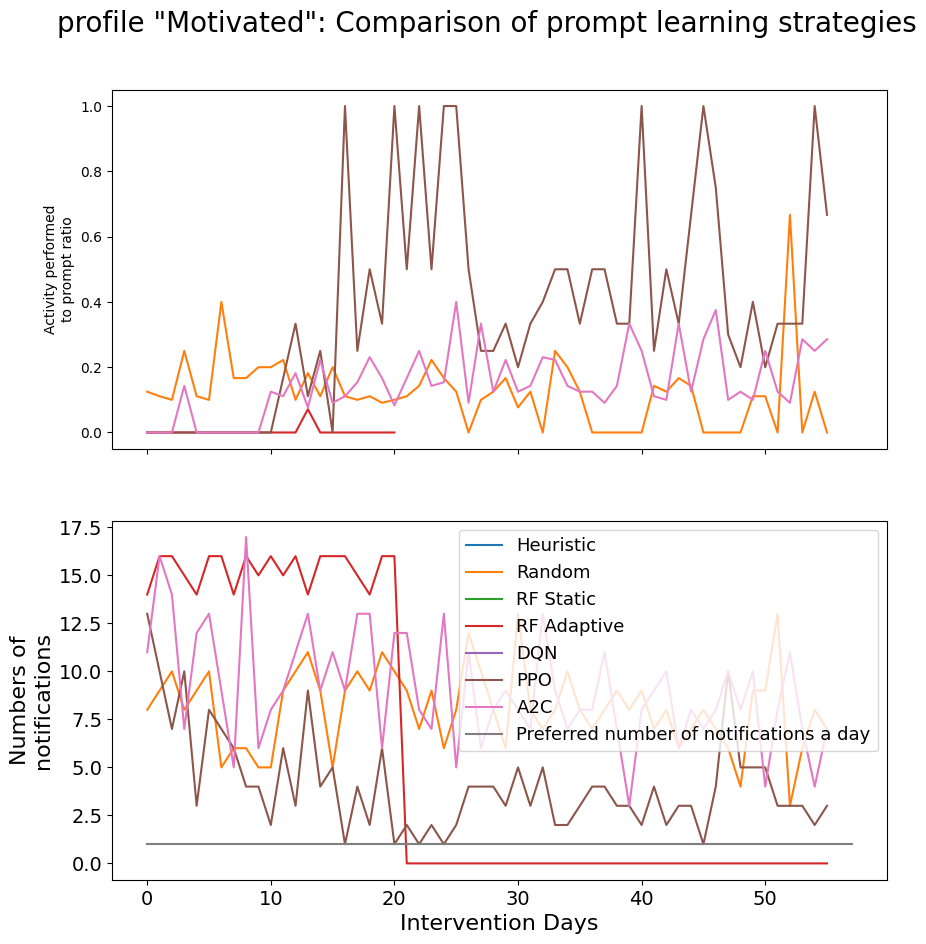


Running experiment for profile: 'Responsive'
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
0 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being performed.
These figures include runs in which no prompt resulted in the activity being performed.
1 out of 1 resulted in activity being perfor

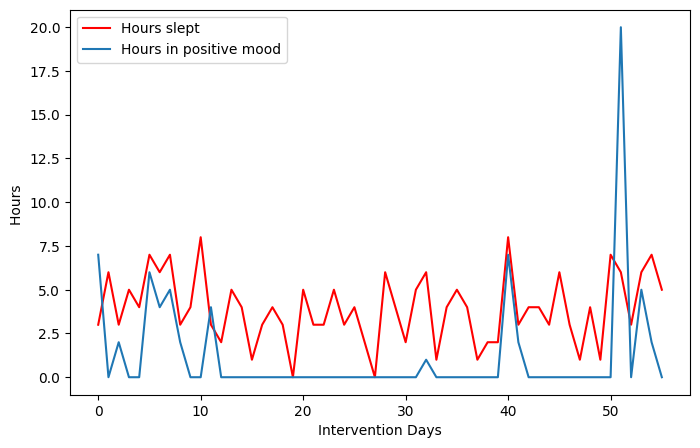

C:\Users\dan\AppData\Local\Temp\ipykernel_8364\3659124082.py:54: RuntimeWarning: Mean of empty slice
  ratios_axis.plot(np.nanmean(ratios, axis=0), label=label)
C:\Users\dan\AppData\Local\Temp\ipykernel_8364\3659124082.py:55: RuntimeWarning: Mean of empty slice
  notifications_axis.plot(np.nanmean(notifications, axis=0), label=label)


Random result: ReadResult(ratios=[0     0.166667
1     0.142857
2     0.100000
3     0.285714
4     0.222222
5     0.200000
6     0.100000
7     0.100000
8     0.125000
9     0.285714
10    0.222222
11    0.090909
12    0.142857
13    0.250000
14    0.142857
15    0.000000
16    0.125000
17    0.090909
18    0.200000
19    0.142857
20    0.166667
21    0.111111
22    0.666667
23    0.142857
24    0.142857
25    0.111111
26    0.200000
27    0.125000
28    0.200000
29    0.100000
30    0.285714
31    0.100000
32    0.400000
33    0.166667
34    0.166667
35    0.100000
36    0.111111
37    0.125000
38    0.181818
39    0.111111
40    0.166667
41    0.111111
42    0.125000
43    0.250000
44    0.090909
45    0.285714
46    0.250000
47    0.111111
48    0.142857
49    0.200000
50    0.200000
51    0.333333
52    0.181818
53    0.250000
54    0.142857
55    0.166667
Name: response_ratio, dtype: float64], notifications=[0      6
1      7
2     10
3      7
4      9
5      5
6     10
7     10


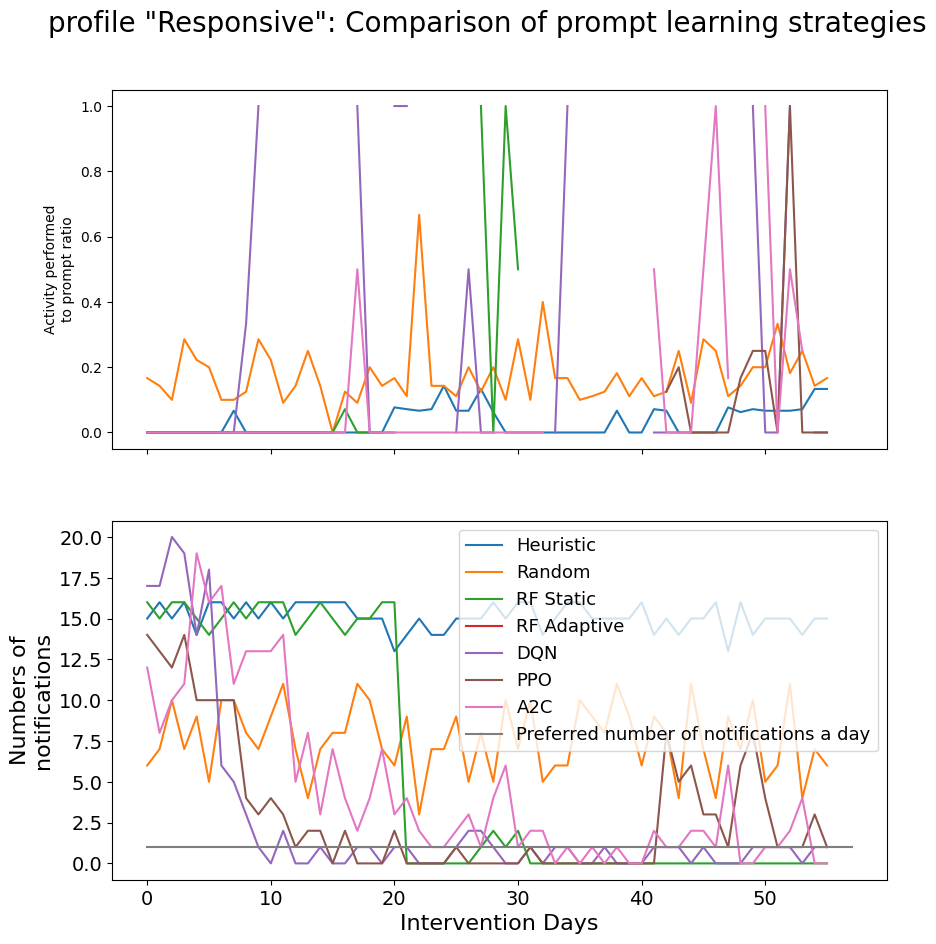

In [28]:
def run_experiment_for_profile(Profile: Type[Patient], label: str):
  print("\tRunning experiments...")
  print("\t - no intervention")
  result = run_no_intervention_experiment(Profile)
  print("\t - heuristic")
  run_intervention_experiment(Profile, always_notify, f'h-{label}')
  print("\t - random")
  run_intervention_experiment(Profile, random_notification, f'random-{label}')
  print("\t - supervised learning")
  run_intervention_experiment(Profile, supervised_adaptive_after_three_weeks, f'static_sup3-{label}')
  print("\t - adaptive supervised learning")
  run_intervention_experiment(Profile, supervised_adaptive_after_three_weeks, f'adaptive_sup3-{label}')
  print("\t - dqn")
  run_intervention_experiment(Profile, dqn, f'dqn-{label}')
  print("\t - ppo")
  run_intervention_experiment(Profile, ppo, f'ppo-{label}')
  print("\t - a2c")
  run_intervention_experiment(Profile, a2c, f'a2c-{label}')
  print("\tDone.")

  always_notify_result = read_ratios_and_notifications(f'h-{label}')
  random_result = read_ratios_and_notifications(f'random-{label}')
  static_sup3_result = read_ratios_and_notifications(f'static_sup3-{label}')
  adaptive_sup3_result = read_ratios_and_notifications(f'adaptive_sup3-{label}')
  dqn_result = read_ratios_and_notifications(f'dqn-{label}')
  ppo_result = read_ratios_and_notifications(f'ppo-{label}')
  a2c_result = read_ratios_and_notifications(f'a2c-{label}')

  plot_experiment_result_hours(result)
  plot_experiment_results_ratio(label, random_result, {
    'Heuristic': always_notify_result,
    'Random': random_result,
    'RF Static': static_sup3_result,
    'RF Adaptive': adaptive_sup3_result,
    'DQN': dqn_result,
    'PPO': ppo_result,
    'A2C': a2c_result
  })

for (label, Profile) in profiles.items():
  print(f"Running experiment for profile: '{label}'")
  run_experiment_for_profile(Profile, label)
  print()
  